# Difference-in-means model

This notebook accompanies [The range of middle theories: Adaptively mapping the experimental design space](). This notebook continues with the motivating question found in the first paragraph of the paper “Do teams perform better than individuals on the same tasks?” Our goal is to measure the difference-in-means between two treatment conditions across the experiment design space. 

This notebook contains the code used to generate Fig. 2 of the paper, and demonstrates how the adaptive sampling techniques described in the second section of the paper may be implemented.

In the previous analysis, we had experimental data from a finite population of micro-experiments. In this notebook, we are going to be choosing which micro-experiment to sample from next, but we will still consider a finite population of possible microexperiments. This reflects a world in which parameters either cannot be continuously adjusted, or in which there is a cost to constructing new micro-experiments.


In [ ]:
# install dependencies
# we specify particular versions for reproducibility
! pip install numpy==1.19.5
! pip install pandas==1.1.2
! pip install matplotlib==3.5.0
! pip install theano-pymc==1.1.2
! pip install pymc3==3.11.4

In [ ]:
%pylab inline
import numpy as np
import pandas as pd
import itertools
import scipy.spatial

import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
from scipy.interpolate import interpn
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"  # ignore some compiler errors

Populating the interactive namespace from numpy and matplotlib


## Generate sample data
This notebook uses the same artificial data generator used for figure 1, with the same random seed.

In [ ]:
rng = np.random.default_rng(1369)  # initialize a random number generator with a fixed seed

def ground_truth(n_facets, n_levels, n_conditions):
    """
    Parameters
    ----------
    n_facets: int >= 1
        number of dimensions in the experiment design space `D`
        
    n_levels: int >= 2
        number of levels to be defined along each dimension
    
    n_conditions: int >= 1
        number of different treatment conditions to be assessed at each point
        
    Returns
    -------
    d_exhaustive: np.array(n_levels^n_facets, n_facets)
        Points in the design space
        - each row is a different point in the space that has a defined ground truth
        - each column is a coordinate along a different dimension in the design space
        
    μ_true: np.array(n_levels^n_facets, n_conditions)
        Outcome values
        - one row for each point in the design space
        - one column for each treatment condition
    """
    
    # Define the design space:
    levels = np.linspace(0, 1, n_levels)
    d_exhaustive = np.array(list(itertools.product(levels, repeat=n_facets)))
    
    # define the rate of change of effects across the design space
    def exponentiated_quadratic(xa, xb, σ):
        """
        Exponentiated quadratic covariance function
        covariance of xa with xb
        according to distance parameter σ

        """
        return np.exp(-1/(2*σ**3) * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean'))
    
    Σ_true = exponentiated_quadratic(d_exhaustive, d_exhaustive, σ=.6)  # covariance matrix 

    
    # define a ground-truth for each comparison
    μ_true = rng.multivariate_normal(
        mean=np.zeros(len(d_exhaustive)), cov=.1*Σ_true, 
        size=n_conditions)

    
    return d_exhaustive, μ_true,
    
n_facets = 1
n_levels = 20
n_conditions = 2
d_exhaustive, μ_true = ground_truth(n_facets, n_levels, n_conditions)


In [ ]:
def choose_js(d_exhaustive, μ_true, J):
    """
    Choose a set of microexperiments to conduct.
    Each microexperiment will have a particular mean that is sampled with noise around μ_true
    this mean varies from the mean of all microexperiments that could have been conducted at that location.
    
    
    Parameters
    ----------
    d_exhaustive: np.array(n_levels^n_facets, n_facets)
        All possible points in the design space that the micro-experiments could be chosen from
        - each row is a different point in the space that has a defined ground truth
        - each column is a coordinate along a different dimension in the design space
        
    μ_true: np.array(n_levels^n_facets, n_conditions)
        Expected value for each treatment condition across all microexperiments that could have been
        conducted at each point in d_exhaustive
        - one row for each point in the design space
        - one column for each treatment condition
    
    J: integer >=1 
        number of microexperiments to conduct
        
        
    Returns
    -------
    d_j: np.array(J, n_facets)
        Locations of each micro-experiment `j` in design space `D`
        
    μ_j: np.array(J, n_conditions)
        Expected value of each condition for each realized micro-experiment
        These are sampled from μ_true with noise
        
    σ_j: np.array(J)
        Noise realized in sampling each micro-experiment
        
    ds: np.array(number of unique locations sampled)
        Unique locations containing one or more micro-experiments
        
    d_index: np.array(J)
        index of each microexperiment in `ds`
    """
 
    n_conditions = μ_true.shape[0]
    indices = rng.integers(len(d_exhaustive), size=J)
    d_j = np.array([d_exhaustive[index,:] for index in indices])

    σμ = .08  # std between multiple microexperiments run at the same point in the design space
    σσ = .08  # average scale of noise of each microexperiment
    
    μ_j = np.array([μ_true[:,index] + rng.normal(scale=σμ, size=n_conditions) for index in indices]) 
    σ_j = rng.gamma(shape=2, scale=σσ, size=J)

    ds = np.unique(d_j, axis=0)  # list of different locations in D-space where we have micro-experiments
    d_index = np.array([np.argwhere(np.all(ds==d, axis=1))[0,0] for d in d_j])  # index of jth microexperiment in ds
    
    assert (all(d_j == ds[d_index]))  # check that we got the arrays right
    return d_j, μ_j, σ_j, ds, d_index


J=30
d_j, μ_j, σ_j, ds, d_index = choose_js(d_exhaustive, μ_true, J)


In [ ]:
def generate_random_sample_points(J, d_j, n_conditions, n):
    """
    Choose some random points and conditions
    
    Parameters
    ----------
    J: integer >=1 
        number of microexperiments available
        
    d_j: np.array(J, n_facets)
        Design-space locations of each micro-experiment available
        
    n_conditions: int >= 1
        number of different treatment conditions available
        
    n: int >= 1
        number of sample points to generate
        
    Returns
    -------
    j: np.array(n)
        indices of the microexperiments from which each sample is taken
        
    d: np.array(n, n_facets)
        design space locations of each sample
        
    X: np.array(n)
        indices of treatment conditions for each sample
    
    """
    j = rng.integers(J, size=n)  # group of the ith sample
    d = d_j[j]  # design space location of the ith sample
    X = rng.integers(n_conditions, size=n)
    return j, d, X

n=1
j, d, X = generate_random_sample_points(J, d_j, n_conditions, n)

In [ ]:
def make_sampler(μ_j, σ_j):
    """
    Create a function returning samples from micro-experiments
    
    Parameters
    ----------
    μ_j: np.array(J, n_conditions)
        Expected value of each condition for each micro-experiment
        These are sampled from μ_true with noise
        
    σ_j: np.array(J)
        Noise with which each micro-experiment is sampled
    
    Returns
    -------
    sample(j, X): function
    
    """
    def sample(j, X):
        """
        Take a sample from the 'real world'
        
        Parameters
        ----------
        j: np.array(n)
            indices of the microexperiments from which each sample is taken
            
        X: np.array(n)
            indices of treatment conditions for each sample
        
        """
        y = [μ_j[ji][Xi] + rng.normal(scale=σ_j[ji]) for ji, Xi in zip(j, X)]
        return  y
    return sample
        
take_samples = make_sampler(μ_j, σ_j)
    
y = take_samples(j, X)

# Adaptive Sampling

The adaptive sampling strategy has its roots in Bayesian Optimization and Active Learning techniques in machine learning. The figure below describes the general adaptive sampling cycle. 

Given any existing data (or appropriate priors) we can (1) fit a generative statistical model to act as a “surrogate” for the true system, across the design space. We can then (2) use this model to predict the outcomes of experiment samples we have yet to collect, given our current understanding of the system. From these predictions, we can (3) calculate the gain in knowledge that we should expect for each candidate sample, and then (4) choose a set of samples to collect based upon the reward, respecting any constraints or design limitations. After we (5) perform an experiment to collect these samples, we then (1) re-fit the surrogate model to all of the data we have collected so far, and repeat the process.


<img src="https://raw.githubusercontent.com/Watts-Lab/adaptive_mapping_paper/407aa5c3047a7a69041bb6a4a0c48ceb2f5f8b4c/ax_loop.png" width="350"/>

## Step 1: Fit a "Surrogate" Model
As the surrogate model in our adaptive sampling loop, we'll use the functional partial pooling model we developed [in the previous notebook]().

The initial fit for the surrogate model will use a few randomly chosen samples.



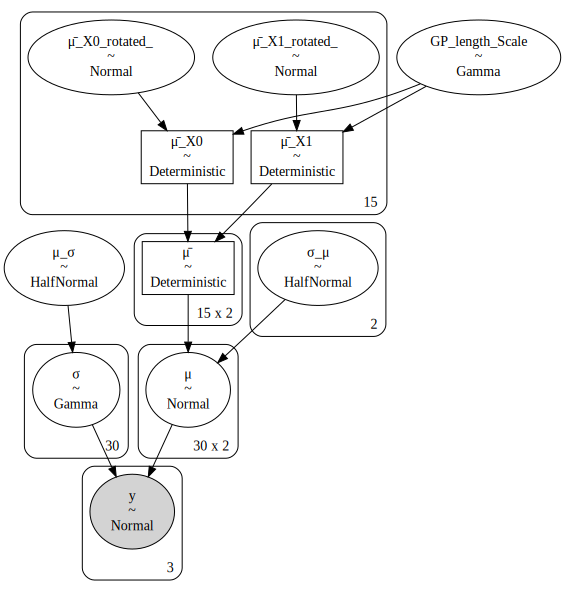

In [ ]:
def build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index):
    
    with pm.Model() as model:
        
        # hyper-hyperpriors for gaussian process
        gp_length_scale_ = pm.Gamma("GP_length_Scale", alpha=2, beta=1, shape=n_facets)  # allow a different length scale for each facet
        
        # hyperpriors for slope and intercept
        cov_func = pm.gp.cov.ExpQuad(n_facets, ls=gp_length_scale_)
        gp_μ̄_ = [pm.gp.Latent(cov_func=cov_func) for i in range(n_conditions)]  # one GP for each treatment
        μ̄_ = pm.Deterministic("μ̄", pm.math.stack([gpi.prior("μ̄_X%i"%i, X=ds, shape=len(ds)) for i, gpi in enumerate(gp_μ̄_)]).T)  # mean for effects prior
      
        σμ_ = pm.HalfNormal("σ_μ", sigma=1, shape=n_conditions)  
        μσ_ = pm.HalfNormal("μ_σ", sigma=1)  # scale parameter for noise prior
    
        # Prior for noise

        μ_ = pm.Normal("μ", mu=μ̄_[d_index,:], sigma=σμ_, shape=(J, n_conditions))
        σ_ = pm.Gamma("σ", alpha=2, beta=μσ_, shape=J)

        # Observations sampled with gaussian noise
        y_ = pm.Normal("y", mu=μ_[j,X], sd=σ_[j], observed=y)
        
    return model
        
    
functional_partial_pooling = build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index)
pm.model_to_graphviz(functional_partial_pooling)



In [ ]:
with functional_partial_pooling:
    functional_partial_pooling_trace = pm.sample()

traces = [functional_partial_pooling_trace]  # save for plotting

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 160 seconds.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 535 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6291406000730155, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


### Step 2: Predict the outcomes of unrealized samples
We now want to predict what we should see in as-yet-unrealized experimental samples. As we have a finite population of possible micro-experiments, we can generate samples for all of the possible micro-experiment treatment combinations.

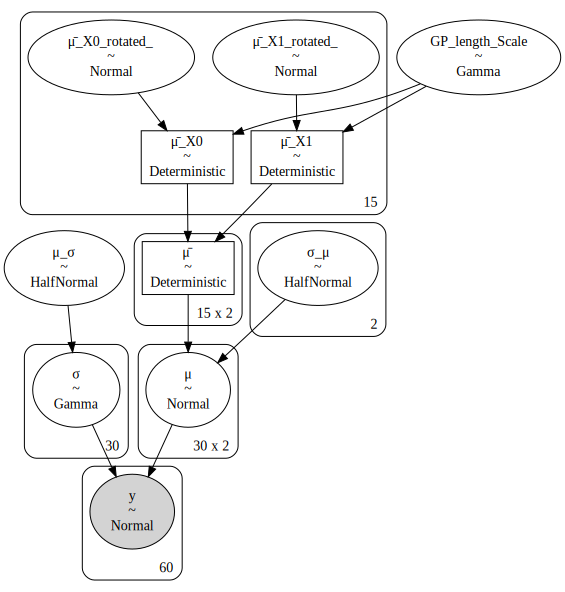

In [ ]:
candidate_j, candidate_X = np.array(list(itertools.product(range(J), range(n_conditions)))).T # all posible microexperiment/treatment combos
candidate_d_index = [d_index[i] for i in candidate_j]
dummy_y = np.zeros(len(candidate_j))

functional_partial_pooling_predictor = build_functional_partial_pooled_model(
    J=J, 
    n_conditions=n_conditions, 
    j=candidate_j, 
    X=candidate_X, 
    y=dummy_y, 
    ds=ds, 
    n_facets=n_facets, 
    d_index=d_index)

pm.model_to_graphviz(functional_partial_pooling_predictor)

In [ ]:
with functional_partial_pooling_predictor:
    predictions = pm.sample_posterior_predictive(functional_partial_pooling_trace, var_names=['y', 'μ', 'μ̄'])

prediction_traces = [predictions]  # save for plotting  

## Step 3: Estimate the "payoff" of sampling at candidate points
Given our posterior predictive sample from the fitted model, we can assess the utility of sampling at each candidate point. 

There are a number of different ways we could measure this utility. For simplicity, we will use the variance of our estimate of the μ parameter - the expected mean performance of all micro-experiments conducted at a particular location - for each condition. We compute this utility for the μ value associated with each candidate trial. 

In [ ]:
# def utility(predictions):
#     X0_var = predictions['μ̄_X0'][:, candidate_d_index].var(axis=0)
#     X1_var = predictions['μ̄_X1'][:, candidate_d_index].var(axis=0)
#     X_var = [X0_var[i] if Xi==0 else X1_var[i] for i, Xi in enumerate(candidate_X)]
#     return X_var

def utility(predictions):
    v = predictions["μ"].var(axis=0)
    
    return [v[cj, cx] for cj, cx in zip(candidate_j, candidate_X)]

def utility(predictions):
    # todo: work out the mapping btw this and microexperiments
    v = predictions["μ̄"].var(axis=0)
    
    return [v[cj, cx] for cj, cx in zip(candidate_j, candidate_X)]

    #return predictions['y'].var(axis=0)

current_utilities = utility(predictions)
current_utilities[:10]  #  display the first 10 values

IndexError: ignored

## Step 4: Select a subset of candidate points

After computing this utility, we select the next sample to take by choosing the microexperiment/condition that maximizes our utility. In this demo, we will select a single point at a time.

In [ ]:
selection = np.argmax(current_utilities)
selection

## Step 5: Collect next samples

From our selected candidate, we identify the next microexperiment `j` and condition `X` to sample from, and take the next sample `y`. These are appended to our existing dataset.

In [ ]:
j = np.append(j, candidate_j[selection])
X = np.append(X, candidate_X[selection])
y = np.append(y, take_samples(candidate_j[[selection]], candidate_X[[selection]]))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 122 seconds.
There were 445 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6050392554630805, but should be close to 0.8. Try to increase the number of tuning steps.
There were 776 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6637059587546766, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## Cycle again 
We now fit the surrogate model again using all of the data we have collected so far.

In [ ]:
functional_partial_pooling = build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index)
with functional_partial_pooling:
    functional_partial_pooling_trace = pm.sample()

traces.append(functional_partial_pooling_trace)

In [ ]:
n_steps = 20
for i in range(n_steps):
    print(list(zip(j, X)))

    # Step 1
    functional_partial_pooling = build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index)
    with functional_partial_pooling:
        functional_partial_pooling_trace = pm.sample()
    traces.append(functional_partial_pooling_trace)

    # Step 2
    with functional_partial_pooling_predictor:
        predictions = pm.sample_posterior_predictive(functional_partial_pooling_trace, var_names=['y', 'μ', 'μ̄_X0', 'μ̄_X1'])
    prediction_traces.append(predictions)

    # Step 3 and 4
    selection = np.argmax(utility(predictions))
    
    # Step 5
    j = np.append(j, candidate_j[selection])
    X = np.append(X, candidate_X[selection])
    y = np.append(y, take_samples(candidate_j[[selection]], candidate_X[[selection]]))
    
    
d = d_j[j]

# Put it all together
We run all of these steps in a loop 

In [ ]:
n_steps = 20
for i in range(n_steps):
    with functional_partial_pooling_predictor:
        predictions = pm.sample_posterior_predictive(functional_partial_pooling_trace, var_names=['y', 'μ', 'μ̄_X0', 'μ̄_X1'])

    selection = np.argmax(utility(predictions))
    
    j = np.append(j, candidate_j[selection])
    X = np.append(X, candidate_X[selection])
    y = np.append(y, take_samples(candidate_j[[selection]], candidate_X[[selection]]))

    functional_partial_pooling = build_functional_partial_pooled_model(J, n_conditions, j, X, y, ds, n_facets, d_index)
    with functional_partial_pooling:
        functional_partial_pooling_trace = pm.sample()
        
    prediction_traces.append(predictions)
    traces.append(functional_partial_pooling_trace)

    print(list(zip(j, X)))
    
d = d_j[j]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 121 seconds.
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
There were 554 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5810998434385037, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 128 seconds.
There were 359 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.649312585539737, but should be close to 0.8. Try to increase the number of tuning steps.
There were 634 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199325058593574, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 140 seconds.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6847871985294041, but should be close to 0.8. Try to increase the number of tuning steps.
There were 659 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6138792704148776, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 130 seconds.
There were 472 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5612629082695164, but should be close to 0.8. Try to increase the number of tuning steps.
There were 853 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6234918984694321, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 169 seconds.
There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 138 seconds.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6778483512525155, but should be close to 0.8. Try to increase the number of tuning steps.
There were 855 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5122448848558716, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 174 seconds.
There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6602391148200096, but should be close to 0.8. Try to increase the number of tuning steps.
There were 409 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 121 seconds.
There were 659 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37677751650164804, but should be close to 0.8. Try to increase the number of tuning steps.
There were 859 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 157 seconds.
There were 248 divergences after tuning. Increase `target_accept` or reparameterize.
There were 781 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5022588283981002, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 123 seconds.
There were 429 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6040876459087645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1372 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19900404762406612, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
There were 224 divergences after tuning. Increase `target_accept` or reparameterize.
There were 716 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5564483772879093, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 175 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
There were 433 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 179 seconds.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
There were 534 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.66578974293391, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 149 seconds.
There were 330 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6263308260999155, but should be close to 0.8. Try to increase the number of tuning steps.
There were 624 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.719478680455813, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 156 seconds.
There were 503 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5458129473787888, but should be close to 0.8. Try to increase the number of tuning steps.
There were 775 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1), (9, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 158 seconds.
There were 860 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29313976766257965, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1065 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1), (9, 1), (20, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 214 seconds.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
There were 453 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6864556270866298, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1), (9, 1), (20, 0), (21, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 131 seconds.
There were 774 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2902829273541944, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6228623055726096, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1), (9, 1), (20, 0), (21, 0), (18, 1)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 173 seconds.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6925866139287198, but should be close to 0.8. Try to increase the number of tuning steps.
There were 709 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6223474533903242, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1), (9, 1), (20, 0), (21, 0), (18, 1), (2, 0)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ, μ_σ, σ_μ, μ̄_X1_rotated_, μ̄_X0_rotated_, GP_length_Scale]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 198 seconds.
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6297579031376586, but should be close to 0.8. Try to increase the number of tuning steps.
There were 703 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


[(19, 0), (7, 0), (28, 0), (22, 1), (19, 1), (4, 0), (12, 0), (23, 1), (4, 1), (11, 0), (6, 0), (8, 1), (21, 1), (3, 0), (0, 0), (2, 1), (8, 0), (3, 1), (9, 1), (20, 0), (21, 0), (18, 1), (2, 0), (28, 1)]


In [ ]:
try:
    assert False
    pd.to_pickle([traces, prediction_traces, d, ds, d_j, X, y, d_exhaustive, μ_true], "sampling_traces.pickle")
    print("data saved")
except:
    [traces, prediction_traces, d, ds, d_j, X, y, d_exhaustive, μ_true] = pd.read_pickle("sampling_traces.pickle")
    print("loaded saved data")

loaded saved data


## Plot result

In [ ]:
plt.rcParams.update({
    "figure.dpi": 100,
    "figure.figsize": (4.5, 4),  # inches
    "figure.facecolor": "white", #"lightyellow",
    
    "savefig.dpi": 150,
    
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 8,
    
    "lines.linewidth": 1,
    "lines.markersize": 4,
    
    "axes.labelsize": 7,
    
    "xtick.labelsize": 6,
    "xtick.major.size": 1,
    
    "ytick.major.size": 0,
    "ytick.labelsize": 6,

    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
    'axes.edgecolor': "silver",
    "axes.linewidth": .5,
    
    "text.usetex": False,
    'mathtext.default': 'regular',

    'legend.fontsize': 6,
    
})

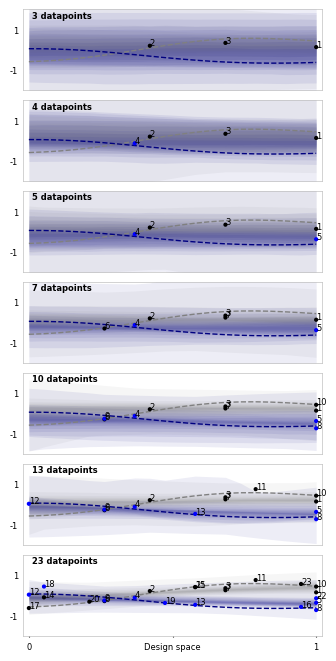

In [ ]:
fig = plt.figure(figsize=(3.25, 6.5), dpi=100, 
                 #facecolor="lightyellow", 
                 constrained_layout=True)

#plot_trace_indices = range(len(traces))
plot_trace_indices = [0,1,2,4,7,10,20]

for row_num, i in enumerate(plot_trace_indices):
    tr = traces[i]

    ax = plt.subplot(len(plot_trace_indices), 1, row_num+1)
    for p in range(0,50,5):
        ax.fill_between(ds.flatten(), *np.percentile(tr['μ̄'][:,:,0], (p, 100-p), axis=0), color='grey', alpha=.07, linewidth=0)
        ax.fill_between(ds.flatten(), *np.percentile(tr['μ̄'][:,:,1], (p, 100-p), axis=0), color='navy', alpha=.07, linewidth=0)

    if i == plot_trace_indices[-1]:
        ax.set_xticks([0,.5,1])
        ax.set_xticklabels([0,"Design space",1])
    else:
        ax.set_xticks([])
    ax.plot(d_exhaustive.flatten(), μ_true[0], '--', color='grey')
    ax.plot(d_exhaustive.flatten(), μ_true[1], '--', color='navy')
    ax.set_ylim(-2, 2)
    ax.set_yticks([-1,1])
    ax.set_yticklabels([-1, 1])

    ax.set_xlim(-.02, 1.02)
    #ax.text(.03,.98, r'$\bar{\mu}$', va="top", weight="bold", transform=ax.transAxes)
    #ax.set_ylabel("outcome", labelpad=0)
    ax.text(.03,.98, r'%i datapoints'%(i+n), va="top", weight="bold", transform=ax.transAxes, fontsize=6)

   
    plt.scatter(d[:i+n],y[:i+n], c=['k' if Xi==0 else 'b' for Xi in X[:i+n]], marker='.', zorder=100);

    for ix in range(i+n):
        plt.annotate(ix+1, (d[ix], y[ix]), fontsize=6, zorder=101)
        
plt.savefig("fig2_model.png", dpi=200)

In [ ]:
len(traces)

22